In [1]:
from functools import partial
from fvhoe.boundary_conditions import BoundaryCondition
from fvhoe.config import primitive_names
from fvhoe.named_array import NamedNumpyArray
from fvhoe.solver import EulerSolver
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# double mach reflection setup

theta = np.pi / 3
xc = 1 / 6


def xp0(x, y):
    return x - y / np.tan(theta)


def xp(x, y, t):
    return (10 * t / np.sin(theta)) + (1 / 6) + (y / np.tan(theta))


# left / right shock values
rho = (8, 1.4)
vx = (7.145, 0)
vy = (-8.25 / 2, 0)
P = (116.5, 1)


# initial condition
def double_mach_reflection_2d(
    x: np.ndarray, y: np.ndarray = None, z: np.ndarray = None
) -> np.ndarray:
    """
    Double Mach reflection
    args:
        x (array_like) : 3D mesh of x-points, shape (nx, ny, nz)
        y (array_like) : 3D mesh of y-points, shape (nx, ny, nz)
        z (array_like) : 3D mesh of z-points, shape (nx, ny, nz)
    returns:
        out (NamedNumpyArray) : has variable names ["rho", "vx", "vy", "vz", "P"]
    """
    out = NamedNumpyArray(np.asarray([np.empty_like(x)] * 5), primitive_names)
    out.rho = np.where(xp0(x, y) < xc, rho[0], rho[1])
    out.vx = np.where(xp0(x, y) < xc, vx[0], vx[1])
    out.vy = np.where(xp0(x, y) < xc, vy[0], vy[1])
    out.vz = 0
    out.P = np.where(xp0(x, y) < xc, P[0], P[1])

    return out


# boundary conditions
def rho_upper(x, y, z, t):
    return np.where(x < xp(x, y, t), rho[0], rho[1])


def vx_upper(x, y, z, t):
    return np.where(x < xp(x, y, t), vx[0], vx[1])


def vy_upper(x, y, z, t):
    return np.where(x < xp(x, y, t), vy[0], vy[1])


def P_upper(x, y, z, t):
    return np.where(x < xp(x, y, t), P[0], P[1])


def mx_upper(x, y, z, t):
    return rho_upper(x, y, z, t) * vx_upper(x, y, z, t)


def my_upper(x, y, z, t):
    return rho_upper(x, y, z, t) * vy_upper(x, y, z, t)


def E_upper(x, y, z, t):
    return P_upper(x, y, z, t) / (1.4 - 1) + 0.5 * (
        mx_upper(x, y, z, t) * vx_upper(x, y, z, t)
        + my_upper(x, y, z, t) * vy_upper(x, y, z, t)
    )

In [3]:
Nx = 256
p = 3

solver = EulerSolver(
    w0=double_mach_reflection_2d,
    bc=BoundaryCondition(
        x=(
            {
                "rho": "dirichlet",
                "E": "dirichlet",
                "mx": "dirichlet",
                "my": "dirichlet",
                "mz": "periodic",
            },
            {
                "rho": "reflective",
                "E": "reflective",
                "mx": "reflective",
                "my": "reflective",
                "mz": "periodic",
            },
        ),
        x_value=(
            {
                "rho": rho[0],
                "E": P[0] / (1.4 - 1) + 0.5 * rho[0] * (vx[0] ** 2 + vy[0] ** 2),
                "mx": rho[0] * vx[0],
                "my": rho[0] * vy[0],
                "mz": None,
            },
            {
                "rho": None,
                "E": None,
                "mx": None,
                "my": None,
                "mz": None,
            },
        ),
        y=(
            {
                "rho": "special-case-double-mach-reflection-y=0",
                "E": "special-case-double-mach-reflection-y=0",
                "mx": "special-case-double-mach-reflection-y=0",
                "my": "special-case-double-mach-reflection-y=0",
                "mz": "periodic",
            },
            {
                "rho": "dirichlet",
                "E": "dirichlet",
                "mx": "dirichlet",
                "my": "dirichlet",
                "mz": "periodic",
            },
        ),
        y_value=(
            {
                "rho": None,
                "E": None,
                "mx": None,
                "my": None,
                "mz": None,
            },
            {
                "rho": rho_upper,
                "E": E_upper,
                "mx": mx_upper,
                "my": my_upper,
                "mz": None,
            },
        ),
    ),
    CFL=0.8,
    x=(0, 4),
    y=(0, 1),
    nx=Nx,
    ny=Nx // 4,
    px=p,
    py=p,
    riemann_solver="llf",
    gamma=1.4,
    density_floor=True,
    pressure_floor=True,
    rho_P_sound_speed_floor=True,
    a_posteriori_slope_limiting=True,
    cupy=True,
)

solver.rkorder(0.2, save_snapshots=False)

100%|██████████| 0.2/0.2 [02:02]                  


t=0.20, x=[0.01, 3.99], y=[0.01, 0.99], z=0.50
horizontal_axis='x', vertical_axis='y'


Text(0, 0.5, '$y$')

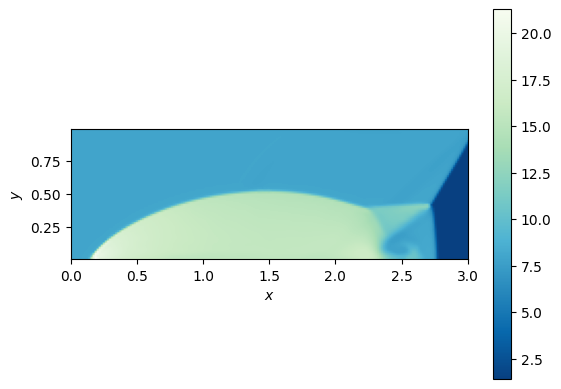

In [4]:
fig, ax = plt.subplots()

im = solver.plot_2d_slice(ax, t=0.2, param="rho", cmap="GnBu_r", z=0.5)
fig.colorbar(im, ax=ax)

ax.set_xlim(0, 3)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")